# Estimate of Public Jupyter Notebooks on GitHub

This notebook shows the historical count and future estimate of the number of `*.ipynb` files on GitHub. The daily count comes from executing the query [extension:ipynb nbformat_minor](https://github.com/search?utf8=%E2%9C%93&q=extension%3Aipynb+nbformat_minor) once a day, on most days. We re-render the notebook and publish it daily after the update.

## Assumptions

1. That the search query hits and notebooks on GitHub are in 1:1 correspondence.
1. That GitHub is accurately reporting the total number of `*.ipynb` file hits.
1. That the result is **not** inflated due to GitHub forks.
    * Evidence: We do not see the tutorial notebooks from the ipython/ipython GitHub repository duplicated in the search results because of the 2,000+ forks of the ipython/ipython repo.
1. That the result **is** inflated a tiny bit by manually created duplicates of notebooks.
    * Evidence: Some people seem to download their favorite notebooks and then upload them into their own git repositories for safe keeping.

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%matplotlib inline

In [3]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

In [4]:
mpl.style.use('ggplot')
figsize = (14,7)

In [5]:
now = datetime.datetime.utcnow()
print(f'This notebook was last rendered at {now} UTC')

This notebook was last rendered at 2019-02-06 22:21:20.474687 UTC


## Raw Hits

First, let's load the historical data into a DataFrame indexed by date.

In [6]:
hits_df = pd.read_csv('ipynb_counts.csv', index_col=0, header=0, parse_dates=True)
hits_df.reset_index(inplace=True)
hits_df.drop_duplicates(subset='date', inplace=True)
hits_df.set_index('date', inplace=True)
hits_df.sort_index(ascending=True, inplace=True)

In [7]:
hits_df.tail(3)

,hits
date,
2019-02-04,3665778
2019-02-05,3672016
2019-02-06,3678858


There might be missing counts for days that we failed to sample. We build up the expected date range and insert NaNs for dates we missed.

In [8]:
til_today = pd.date_range(hits_df.index[0], hits_df.index[-1])

In [9]:
hits_df = hits_df.reindex(til_today)

Now we plot the known notebook counts for each day we've been tracking the query results.

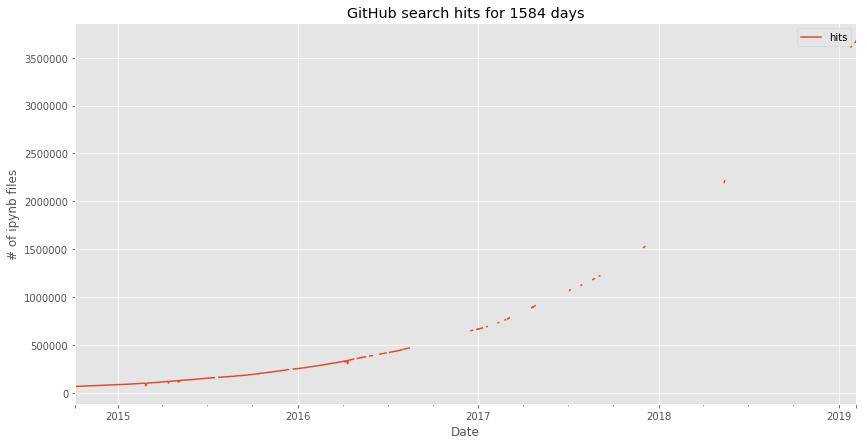

In [10]:
ax = hits_df.plot(title=f"GitHub search hits for {len(hits_df)} days", figsize=figsize)
ax.set_xlabel('Date')
ax.set_ylabel('# of ipynb files');

## Smoothed Hits

The outliers in the data are from GitHub reporting drastically different counts when we sample. We suspect this happens when they rebuild their search index. We'll filter them out now by removing any daily change greater than 2.5 standard deviations from the mean daily change.

In [11]:
daily_deltas = (hits_df.hits - hits_df.hits.shift()).fillna(0)

In [12]:
outliers = abs(daily_deltas - daily_deltas.mean()) > 2.5*daily_deltas.std()

In [13]:
hits_df.loc[outliers] = np.NaN

Now we do simple linear interpolation for any missing values over days that we failed to sample and days that had outlier counts.

In [14]:
hits_df = hits_df.interpolate(method='time')

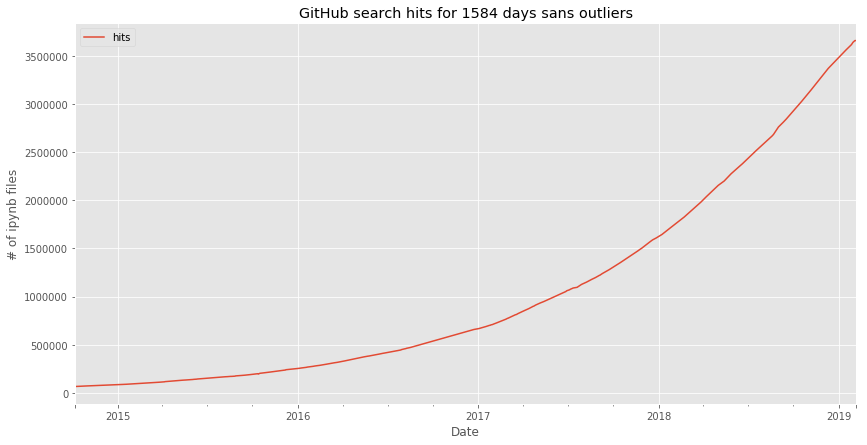

In [15]:
ax = hits_df.plot(title=f"GitHub search hits for {len(hits_df)} days sans outliers", 
                  figsize=figsize)
ax.set_xlabel('Date')
_ = ax.set_ylabel('# of ipynb files')

The total change in the number of `*.ipynb` hits between the tracking start date and today is:

In [16]:
total_delta_nbs = hits_df.iloc[-1] - hits_df.iloc[0]
total_delta_nbs

hits    3591617.0
dtype: float64

## Daily Change

The daily average change for the entire duration.

In [17]:
avg_delta_nbs = total_delta_nbs / len(hits_df)
avg_delta_nbs

hits    2267.434975
dtype: float64

We can look at the daily change over the entire period. We can also plot the rolling 30-day mean of the daily deltas.

In [18]:
daily_deltas = (hits_df.hits - hits_df.hits.shift()).fillna(0)

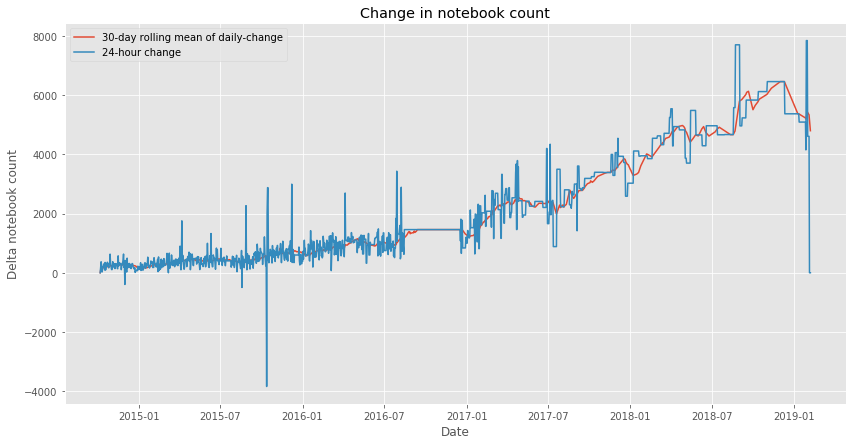

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(daily_deltas.rolling(window=30, min_periods=0, center=False).mean(), 
        label='30-day rolling mean of daily-change')
ax.plot(daily_deltas, label='24-hour change')
ax.set_xlabel('Date')
ax.set_ylabel('Delta notebook count')
ax.set_title('Change in notebook count')
_ = ax.legend(loc='upper left')

Let's look at the rolling mean in isolation.

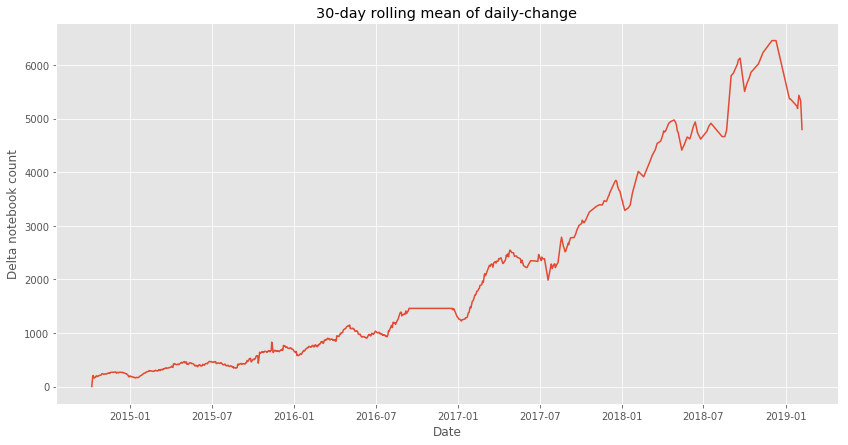

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(daily_deltas.rolling(window=30, min_periods=0, center=False).mean())
ax.set_xlabel('Date')
ax.set_ylabel('Delta notebook count')
_ = ax.set_title('30-day rolling mean of daily-change')

## Count Prediction

We next train an [autoregressive model](http://en.wikipedia.org/wiki/Autoregressive_model) on the prior year of data. We then use the model to predict the number of notebooks on GitHub a year from now.

In [21]:
delta = datetime.timedelta(365)

In [22]:
train_df = hits_df.loc[now.date()-delta:]
model = sm.tsa.AR(train_df, freq='D').fit(ic='aic')
model.params

const       339.231273
L1.hits       1.992117
L2.hits      -1.006194
L3.hits      -0.189060
L4.hits       0.700706
L5.hits      -0.798305
L6.hits       0.251680
L7.hits      -0.260528
L8.hits       0.691590
L9.hits      -0.455060
L10.hits     -0.119286
L11.hits      0.401408
L12.hits     -0.209077
dtype: float64

We predict counts through a full year in the future.

In [23]:
pred_s = model.predict(
    (now.date()-delta + datetime.timedelta(model.k_ar)).strftime('%Y-%m-%d'),
    (now.date()+delta).strftime('%Y-%m-%d'),
    dynamic=True
)

Now we can plot the truth and prediction.

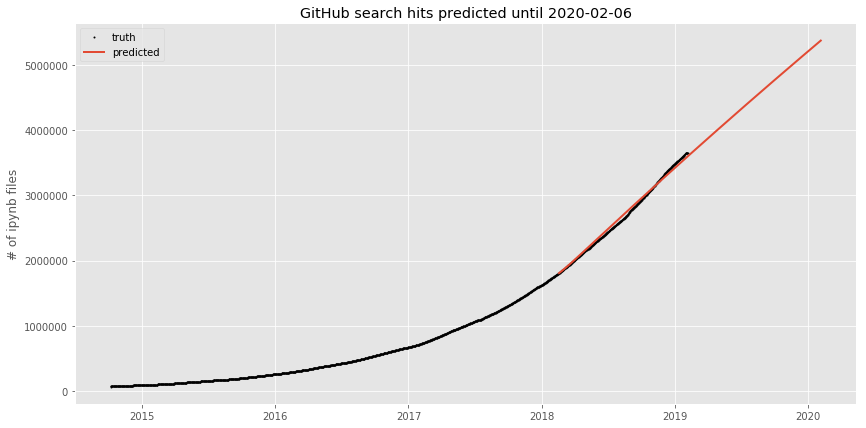

In [24]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'GitHub search hits predicted until {now.date()+delta}')
# plot the raw search numbers
ax.plot(hits_df, 'ko', markersize=1, label='truth')
# use the pandas plotting api mostly because it formats the legend for us
ax.plot(pred_s, linewidth=2, label='predicted')
# show labels
ax.legend()
_ = ax.set_ylabel('# of ipynb files')

We plot the residuals to get a sense of how well the model matches recent observations.

In [25]:
eval_df = pred_s.to_frame(name='predicted')
eval_df['truth'] = hits_df.hits

In [26]:
residual_df = -eval_df.subtract(eval_df.truth, axis=0).dropna().drop('truth', axis=1)
_ = eval_df.drop('truth', axis=1)

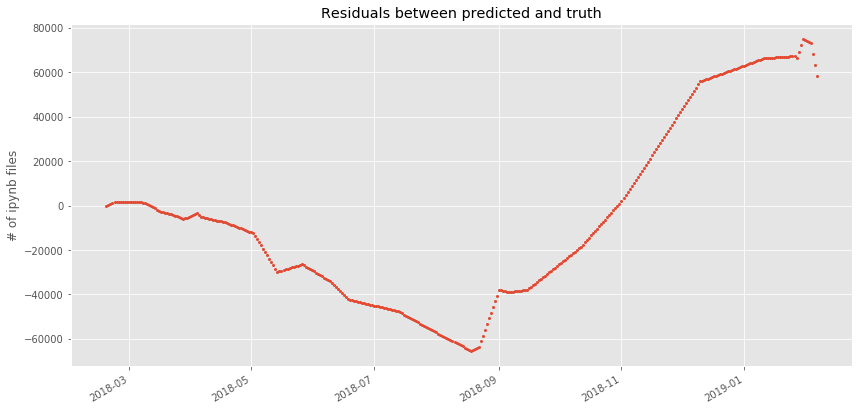

In [27]:
fig, ax = plt.subplots(figsize=figsize)
ret = ax.plot(residual_df, 'o', ms=2)
ax.set_ylabel('# of ipynb files')
ax.set_title('Residuals between predicted and truth')
fig.autofmt_xdate()